## Installs

In [ ]:
!apt-get update && apt-get install -y libsndfile1 ffmpeg
!pip install Cython packaging
!pip install nemo_toolkit['asr']
!pip install megatron-core

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,561 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Get:13 https://ppa.launchpadcontent.net/graphics-drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


## Imports

In [ ]:
import numpy as np
import os
import nemo
import nemo.collections.asr as nemo_asr
import nemo.lightning as nl

## Clone jeli-data-manifest Hugging Face

Clone the HF git repo holding the data for the Nemo compatible version of Jeli-ASR

In [ ]:
# Download the audios with wget
!wget https://huggingface.co/datasets/RobotsMali/jeli-asr/resolve/archives/audio-archives/jeli-asr-1.0.0-audios.tar.gz
# Download the manifests in the same way
!wget https://huggingface.co/datasets/RobotsMali/jeli-asr/resolve/archives/manifests-archives/jeli-asr-1.0.1-manifests.tar.gz

--2025-01-22 16:09:14--  https://huggingface.co/datasets/RobotsMali/jeli-asr/resolve/archives/audio-archives/jeli-asr-1.0.0-audios.tar.gz
Resolving huggingface.co (huggingface.co)... 18.239.50.80, 18.239.50.16, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.80|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/94/ca/94caa9299e357a643629fdcb2de0f148d1013de67ca0c318859c7353d3747165/d060f79286ca251b654c44871cc0aaf47f26f89227cc07fb951b520b911bdb81?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27jeli-asr-1.0.0-audios.tar.gz%3B+filename%3D%22jeli-asr-1.0.0-audios.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1737565754&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzU2NTc1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzk0L2NhLzk0Y2FhOTI5OWUzNTdhNjQzNjI5ZmRjYjJkZTBmMTQ4ZDEwMTNkZTY3Y2EwYzMxODg1OWM3MzUzZDM3NDcxNjUvZ

In [ ]:
# untar the audios
!tar -xzf jeli-asr-1.0.0-audios.tar.gz
# untar the manifests
!tar -xzf jeli-asr-1.0.1-manifests.tar.gz

In [ ]:
# Take a look at the directory structure
!ls jeli-asr

bam-asr-oza  french-manifests  jeli-asr-rmai  manifests


In [ ]:
import IPython.display as ipd
import librosa

# Load and listen to the audio file
example_file = 'jeli-asr/bam-asr-oza/train/split1/oza75-bam-asr-0.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers:

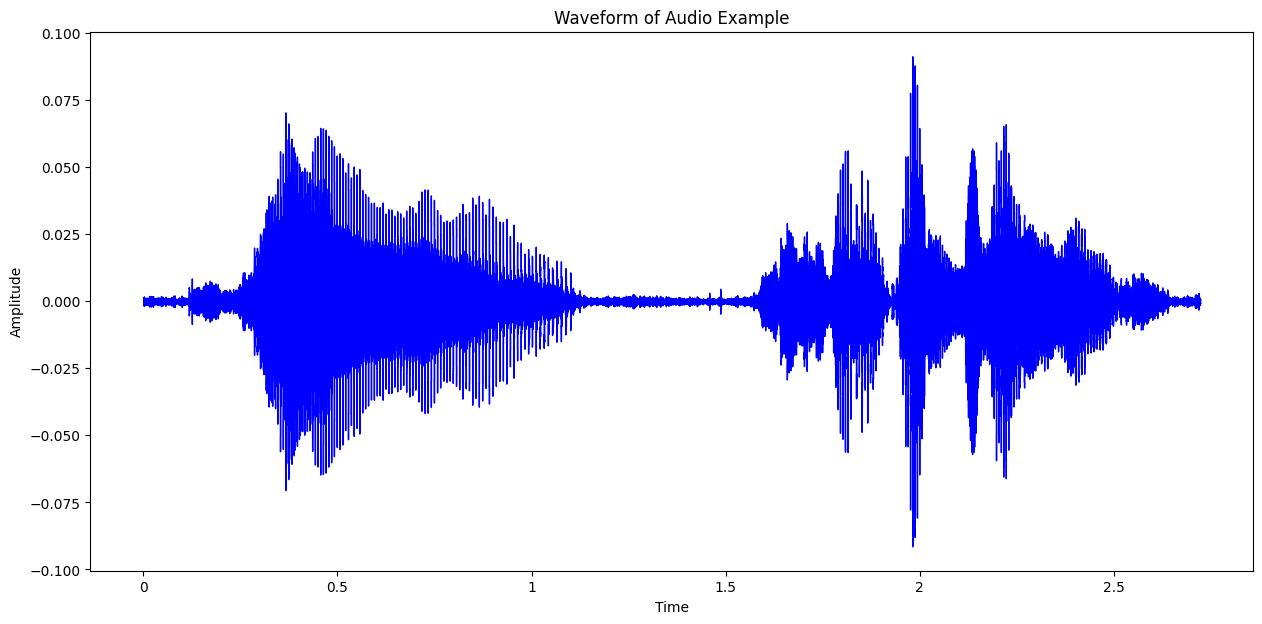

In [ ]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

### Spectrograms and Mel Spectrograms

However, since audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values.
We can apply a [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) on our audio signal to get something more useful: a **spectrogram**, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file.
A spectrogram (which can be viewed as a heat map) is a good way of seeing how the *strengths of various frequencies in the audio vary over time*, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

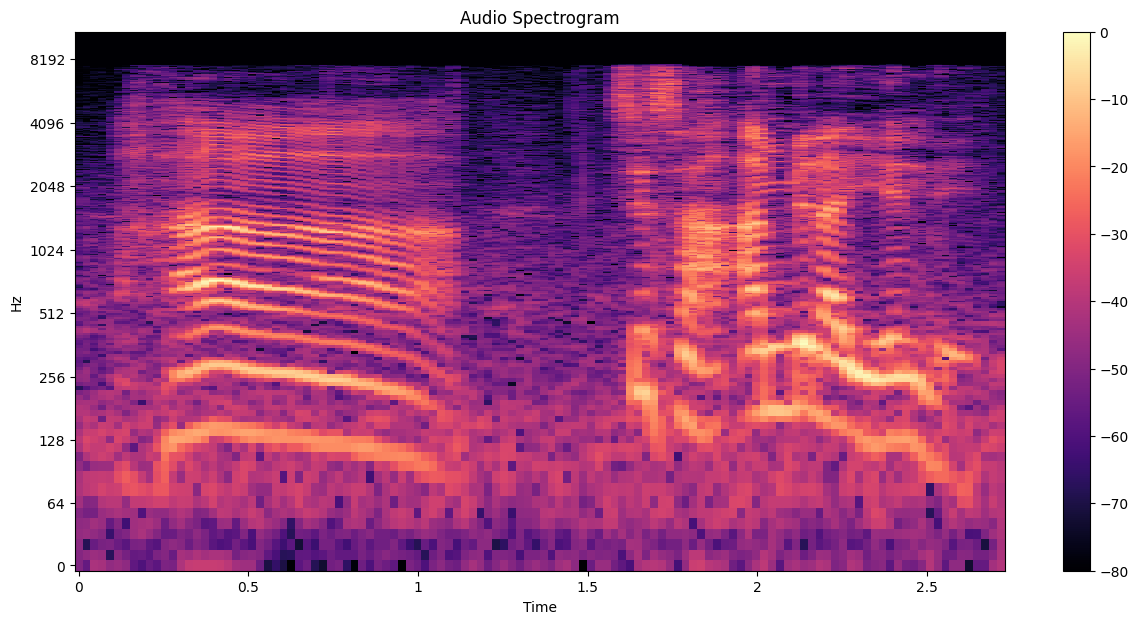

In [ ]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

## Using a pretrained Models in NeMo hub

In [ ]:
list_of_available_models = nemo_asr.models.EncDecCTCModel.list_available_models()
list_of_available_models[:3]

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice                 (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English.                     It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of                     3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit                         https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ),
 PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/v

In [ ]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2025-01-22 18:08:32 nemo_logging:393] Found existing object /root/.cache/torch/NeMo/NeMo_2.1.0/QuartzNet15x5Base-En/b69977d31abaf2ab3e8f082866f6dfcb/QuartzNet15x5Base-En.nemo.
[NeMo I 2025-01-22 18:08:32 nemo_logging:393] Re-using file from: /root/.cache/torch/NeMo/NeMo_2.1.0/QuartzNet15x5Base-En/b69977d31abaf2ab3e8f082866f6dfcb/QuartzNet15x5Base-En.nemo
[NeMo I 2025-01-22 18:08:32 nemo_logging:393] Instantiating model from pre-trained checkpoint
[NeMo I 2025-01-22 18:08:33 nemo_logging:393] PADDING: 16
[NeMo I 2025-01-22 18:08:34 nemo_logging:393] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.1.0/QuartzNet15x5Base-En/b69977d31abaf2ab3e8f082866f6dfcb/QuartzNet15x5Base-En.nemo.


Note that attempting to transcribe Bambara without fine tuning or changing Vocab will fail. This will result in a shape mismatch error from the encoder

In [ ]:
# Get an english audio sample to test QuartzNet15x5Base-En
!wget -O sample_english_audio.wav "http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav"

--2025-01-22 16:12:06--  http://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav
Resolving www.voiptroubleshooter.com (www.voiptroubleshooter.com)... 162.241.218.124
Connecting to www.voiptroubleshooter.com (www.voiptroubleshooter.com)|162.241.218.124|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538014 (525K) [audio/x-wav]
Saving to: ‘sample_english_audio.wav’

sample_english_audi 100%[===================>] 525.40K   701KB/s    in 0.7s    

2025-01-22 16:12:07 (701 KB/s) - ‘sample_english_audio.wav’ saved [538014/538014]



In [ ]:
ipd.Audio('sample_english_audio.wav', autoplay=True)

In [ ]:
transcription = quartznet.transcribe(audio='sample_english_audio.wav')
transcription

Transcribing: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


['the birch canoe slid on the smooth planks glue the sheat to the dark blue background it is easy to tell the depth over well these days a chicken legg ey raredish rice is often served in roundbowls the juice of lemons makes fine punch the box was done beside the park truck the hogs ere fed chopped corn and garbage four hours of study work faced us a large size in stockings is hard to sell']

## Data Augmentation

There exist several ASR data augmentation methods that can increase the size of our training set.

For example, we can perform augmentation on the spectrograms by zeroing out specific frequency segments ("frequency masking") or time segments ("time masking") as described by [SpecAugment](https://arxiv.org/abs/1904.08779), or zero out rectangles on the spectrogram as in [Cutout](https://arxiv.org/pdf/1708.04552.pdf). In NeMo, we can do all three of these by simply adding in a `SpectrogramAugmentation` neural module. (As of now, it does not perform the time warping from the SpecAugment paper.)

The quartznet model we got from cloud implement that feature:

In [ ]:
print(quartznet._cfg['spec_augment'])

{'_target_': 'nemo.collections.asr.modules.SpectrogramAugmentation', 'rect_freq': 50, 'rect_masks': 5, 'rect_time': 120}


### Transfer learning with Nemo

Transfer learning with NeMo is simple. Let's demonstrate how the model we got from the cloud could be fine-tuned on jeli-asr data.

In [ ]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)
new_vocab = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
             'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
             'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
             'w', 'x', 'y', 'z', ' ', "'", '-', 'ŋ', 'ɔ', 'ɛ', 'ɲ']
# Note that you can (and should!) change the vocabulary
# entirely when fine-tuning using a different language.
quartznet.change_vocabulary(
    new_vocabulary=new_vocab
)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
[NeMo I 2025-01-22 18:08:40 nemo_logging:393] Changed decoder to output to ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', "'", '-', 'ŋ', 'ɔ', 'ɛ', 'ɲ'] vocabulary.


After this, our decoder has completely changed, but our encoder (which is where most of the weights are) remained intact. Let's fine tune this model for 20 epochs on jeli-asr dataset.

In [ ]:
!ls jeli-asr/manifests

jeli-asr-rmai-test-manifest.json   oza-bam-asr-test-manifest.json   test-manifest.json
jeli-asr-rmai-train-manifest.json  oza-bam-asr-train-manifest.json  train-manifest.json


Note that you might need to apply other preprocessing steps with another dataset. I filtered and modified jeli-asr to run smothly with nemo. You might also want to apply your own preprocessing strategy but no further

In [ ]:
import json

def exclude_rmai_subset_from_training(manifest_path, output_manifest_path):
    """
    Create a new training manifest without the jeli-asr-rmai subset.

    Args:
        manifest_path (str): Path to the input manifest file.
        output_manifest_path (str): Path to save the filtered manifest.

    Returns:
        None
    """
    with open(manifest_path, 'r', encoding='utf-8') as f:
        manifest = [json.loads(line.strip()) for line in f]

    # Filtering
    filtered_manifest = [entry for entry in manifest if 'jeli-asr-rmai/' not in entry['audio_filepath']]

    # Write the filtered manifest to the output file
    with open(output_manifest_path, 'w', encoding='utf-8') as f:
        for entry in filtered_manifest:
            f.write(json.dumps(entry) + '\n')

    print(f"Filtered manifest saved to {output_manifest_path}")

# filter the data to remove the samples from jeli-asr-rmai
exclude_rmai_subset_from_training('jeli-asr/manifests/train-manifest.json', 'train-manifest.json')

Filtered manifest saved to train-manifest.json


In [ ]:
!wc -l train-manifest.json jeli-asr/manifests/train-manifest.json

   30685 train-manifest.json
   32180 jeli-asr/manifests/train-manifest.json
   62865 total


Nemo used to use yaml files for models and optimizers configuration. They changed for a programmatical approach in Nemo 2.0 (which I'm currently using) but you can still use yaml files are archives to save for traning parameter. I'm unsure of it but it also seems that the yaml config is still supported for ASR in this early version of Nemo 2.0

In [ ]:
# Define Training and validation dataloaders' configs
train_data_config = {
    'manifest_filepath': 'jeli-asr/manifests/train-manifest.json',
    'sample_rate': 16000,
    'max_duration': 30,
    'num_workers': 0,
    'shuffle': True,
    'batch_size': 8,
    'labels': new_vocab
}

valid_data_config = {
    'manifest_filepath': 'jeli-asr/manifests/test-manifest.json',
    'sample_rate': 16000,
    'max_duration': 45,
    'num_workers': 0,
    'shuffle': False,
    'batch_size': 8,
    'labels': new_vocab
}

# Define the parameters for the optimizer
optim_config = {
    'name': 'novograd',
    'lr': 0.001, # 1e-3
    'betas': [0.8, 0.5],
    'weight_decay': 0.001,
    'sched': {
        'name': 'CosineAnnealing',
        'monitor': 'val_loss',
        'reduce_on_plateau': False,
        'warmup_steps': None,
        'warmup_ratio': None,
        'min_lr': 0.0,
        'last_epoch': -1,
    },
}

# Define the preprocessor
preprocessor_cfg = {
    '_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor',
    'sample_rate': 16000,
    'window_size': 0.02,
    'window_stride': 0.01,
    'window': 'hann',
    'features': 80,
    'n_fft': 512,
    'log': True,
    'normalize': 'per_feature',
}

In [ ]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=optim_config)

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=train_data_config)

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=valid_data_config)

[NeMo W 2025-01-22 18:10:35 nemo_logging:405] Trainer wasn't specified in model constructor. Make sure that you really wanted it.


[NeMo I 2025-01-22 18:10:35 nemo_logging:393] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2025-01-22 18:10:35 nemo_logging:405] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2025-01-22 18:10:35 nemo_logging:393] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-01-22 18:10:35 nemo_logging:393] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] Dataset loaded with 32098 files totalling 30.18 hours
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] 82 files were filtered totalling 0.85 hours
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] Dataset loaded with 1463 files totalling 1.44 hours
[NeMo I 2025-01-22 18:10:36 nemo_logging:393] 0 files were filtered totalling 0.00 hours


### Training with PyTorch Lightning

NeMo models and modules can be used in any PyTorch code where torch.nn.Module is expected.

However, NeMo's models are based on [PytorchLightning's](https://github.com/PyTorchLightning/pytorch-lightning) LightningModule and we recommend you use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs

In [ ]:
class PrintValidationMetricsCallback(nl.pytorch.callbacks.ModelCallback):
    def on_validation_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        print(f"Epoch {trainer.current_epoch} Validation Metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")


In [ ]:
from nemo.lightning.pytorch.callbacks import ModelCheckpoint
from nemo.lightning import NeMoLogger
from pytorch_lightning.loggers import TensorBoardLogger
from nemo.lightning import AutoResume

# Define a model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    save_weights_only = True,
    always_save_context = False,
    save_context_on_train_end = False,
    save_last=True,
    monitor="val_loss",
    save_top_k=2,
    every_n_train_steps=500,
)

# Define a logger
logger = nemo_logger = NeMoLogger(
    log_dir='logs',
    name='quartzNet-experiment1',
    use_datetime_version=False,
    update_logger_directory=True,
    ckpt=checkpoint_callback,
)

# Define the auto-resume policy
resume = AutoResume(
    resume_if_exists=False,
    resume_ignore_no_checkpoint=True,
)

# Define a Pytorch lighthing trainer object
trainer = nl.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=2,
    # This is very likely the max value of accumulated gradients for this dataset (with 'max_duration': 45) on Colab, without running out of gpu memory
    accumulate_grad_batches=8,
    check_val_every_n_epoch=1,
    logger=True,
    enable_progress_bar=True,
    callbacks=[PrintValidationMetricsCallback(),]
)

nemo_logger.setup(
    trainer,
    getattr(resume, "resume_if_exists", False),
)
resume.setup(trainer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[NeMo I 2025-01-22 18:10:43 nemo_logging:393] Experiments will be logged at logs/quartzNet-experiment1


[NeMo W 2025-01-22 18:10:43 nemo_logging:405] "update_logger_directory" is True. Overwriting tensorboard logger "save_dir" to logs
[NeMo W 2025-01-22 18:10:43 nemo_logging:405] The Trainer already contains a ModelCheckpoint callback. This will be overwritten.


In [ ]:
trainer.fit(quartznet)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2025-01-22 18:10:47 nemo_logging:393] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )
[NeMo I 2025-01-22 18:10:47 nemo_logging:393] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fae55fa7850>" 
    will be used during training (effective maximum steps = 1004) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1004
    )


INFO: 
  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConvASREncoder                    | 18.9 M | train
2 | spec_augmentation | SpectrogramAugmentation           | 0      | train
3 | wer               | WER                               | 0      | train
4 | decoder           | ConvASRDecoder                    | 45.1 K | train
5 | loss              | CTCLoss                           | 0      | train
--------------------------------------------------------------------------------
18.9 M    Trainable params
0         Non-trainable params
18.9 M    Total params
75.759    Total estimated model params size (MB)
607       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name              | Type                              | Param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Metrics:
global_step: 0.0000
val_loss: 476.5983
val_wer: 1.0000


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 500: 'val_loss' was not in top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Validation Metrics:
train_loss: 37.7957
learning_rate: 0.0005
global_step: 502.0000
training_batch_wer: 0.8209
val_loss: 52.3821
val_wer: 0.7397


INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1000: 'val_loss' reached 52.38214 (best 52.38214), saving model to 'logs/quartzNet-experiment1/checkpoints/quartzNet-experiment1--val_loss=52.3821-epoch=1-consumed_samples=0.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation Metrics:
train_loss: 41.2654
learning_rate: 0.0000
global_step: 1004.0000
training_batch_wer: 0.7465
val_loss: 49.2420
val_wer: 0.7218


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
!ls logs/

lightning_logs	quartzNet-experiment1


In [ ]:
# Show validation metrics
trainer.logged_metrics

{'train_loss': tensor(41.2654),
 'learning_rate': tensor(2.4478e-09),
 'global_step': tensor(1004.),
 'training_batch_wer': tensor(0.7465),
 'val_loss': tensor(49.2420),
 'val_wer': tensor(0.7218)}

## Inferencing

In [ ]:
display(ipd.Audio('jeli-asr/jeli-asr-rmai/test/griots_r10-1052382-1061140.wav', autoplay=True))

In [ ]:
quartznet.transcribe(["jeli-asr/jeli-asr-rmai/test/griots_r10-1052382-1061140.wav",])


Transcribing: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


['aba foduna bɛ mi e bɛ taama miɲɛ musɔkɔrɔba nana sarii mina bɛ ama yi bɛ ta dunɛ biele']

## Saving a model and restoring a model

In [ ]:
# Save the trained model as a .nemo archive
quartznet.save_to('quartznet-finetuned-jeli.nemo')

# Note: you can also push your trained models to Hugging Face

To restore a model from an archive simply:

```
# Restore a model from an archive
model = nemo_asr.models.<MODEL_BASE_CLASS>.restore_from(restore_path="<path/to/checkpoint/file.nemo>")
```

Where the model base class is the ASR model class of the original checkpoint such as EncDecCTCModel, or the general ASRModel class.

Note that this is a different method than "EncDecCTCModel.from_pretrained" which is used to load checkpoints from Nemo NGC or Hugging Face


## Push to Hugging Face HUB

In [ ]:
# Write your own model card class
class ModelCard:
  def __init__(self, model_name):
    self.model_name = model_name

  def __repr__(self):
    template = """This is the {model_name} model""".format(model_name=self.model_name)
    return template

model.push_to_hf_hub(
    repo_id=repo_id, token=token, model_card=MyModelCard("ABC"),
    pack_nemo_file=True, commit_message="Commit Message",
)